In [121]:
import sys
import requests as r
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
%matplotlib inline

In [122]:
url = "https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v2"
query1 = """query trades{
  swaps(where:{pair: "0xd3d2e2692501a5c9ca623199d38826e513033a17"}, orderBy: timestamp, orderDirection: desc, first: 1000) {
    id
    timestamp
    amount0In
    amount1In
    amount0Out
    amount1Out
    amountUSD
    pair {
      volumeUSD
    }
  }
}"""
query2 = """query tt{
  pairs(where: {id: "0xd3d2e2692501a5c9ca623199d38826e513033a17"}, orderBy: createdAtTimestamp, orderDirection: desc)
  {
    id
    token0{
      name
    }
    token1{
      name
    }
    totalSupply
    reserveUSD
    token0Price
    token1Price
    volumeUSD
    txCount
    liquidityProviderCount
    createdAtBlockNumber
  }
}"""

In [123]:
req = r.post(url, json={'query': query1})

In [124]:
print(req.status_code)
#print(req.text)

200


In [125]:
json_data = json.loads(req.text)
df_data = json_data['data']['swaps']
df = pd.DataFrame(df_data)

In [126]:
buy_side = []
base, quote = [], []

In [127]:
for a in df["amount0In"]:
    if (float(a) == 0):
        buy_side.append("Sell")
    else:
        buy_side.append("Buy")

In [128]:
for a, b, c, d in zip(df["amount0In"], df["amount0Out"],df["amount1In"],df["amount1Out"]):
    temp = float(a) + float(b)
    base.append(temp)
    tt = float(c) + float(d)
    quote.append(tt)

In [129]:
df["Side (Buy/Sell)"] = buy_side
df["Base currency  qty. traded"] = base
df["Quote currency  qty. traded"] = quote
del df["amount0In"],df["amount0Out"],df["amount1In"],df["amount1Out"]

In [130]:
vol_usd = []
for a in df['pair']:
    vol_usd.append(float(a['volumeUSD']))
df['Volume in USD'] = vol_usd
del df['pair']

In [131]:
df.rename(columns={'amountUSD': 'USD amount', 'id': 'Pool ID', 'timestamp': 'Timestamp'}, inplace=True)

In [132]:
convert_dict = {"USD amount": float}
df = df.astype(convert_dict)

In [133]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"], unit = "s")

In [134]:
df.head()

,USD amount,Pool ID,Timestamp,Side (Buy/Sell),Base currency qty. traded,Quote currency qty. traded,Volume in USD
0,79.043152,0xfbb43e35db04f3d88212e2eac94b1429c13eef22af50...,2021-06-25 05:06:42,Sell,4.439820,0.040000,6.640779e+09
1,78.476562,0x3db4afd3841fc32b8eeeea9ae67f850e0cecbf6b8847...,2021-06-25 04:54:44,Sell,4.400989,0.039650,6.640779e+09
2,954.041329,0x48d345e41db439a93425dd9626a33304d1c067541d61...,2021-06-25 04:53:53,Buy,53.823101,0.482016,6.640779e+09
3,5192.199557,0xe7982f7267361e08cc30c43f742abbafdb1345829244...,2021-06-25 04:52:37,Buy,292.847928,2.623014,6.640779e+09
4,9289.740033,0x7e61574cee2a5b60672d490698c5c1efa24a25009515...,2021-06-25 04:52:37,Buy,523.768366,4.693025,6.640779e+09


In [135]:
df2 = df
df = df.set_index('Timestamp')
df.head()

,USD amount,Pool ID,Side (Buy/Sell),Base currency qty. traded,Quote currency qty. traded,Volume in USD
Timestamp,,,,,,
2021-06-25 05:06:42,79.043152,0xfbb43e35db04f3d88212e2eac94b1429c13eef22af50...,Sell,4.439820,0.040000,6.640779e+09
2021-06-25 04:54:44,78.476562,0x3db4afd3841fc32b8eeeea9ae67f850e0cecbf6b8847...,Sell,4.400989,0.039650,6.640779e+09
2021-06-25 04:53:53,954.041329,0x48d345e41db439a93425dd9626a33304d1c067541d61...,Buy,53.823101,0.482016,6.640779e+09
2021-06-25 04:52:37,5192.199557,0xe7982f7267361e08cc30c43f742abbafdb1345829244...,Buy,292.847928,2.623014,6.640779e+09
2021-06-25 04:52:37,9289.740033,0x7e61574cee2a5b60672d490698c5c1efa24a25009515...,Buy,523.768366,4.693025,6.640779e+09


In [136]:
df2["Date"] = df2['Timestamp'].dt.date

In [137]:
sns.set(rc={'figure.figsize':(11, 4)})

In [138]:
df2 = df2.groupby('Date')

In [139]:
df2.sum()

,USD amount,Base currency qty. traded,Quote currency qty. traded,Volume in USD
Date,,,,
2021-06-22,3.376892e+03,209.141011,1.821054,2.656312e+10
2021-06-23,3.612408e+06,206409.854148,1841.645734,3.127807e+12
2021-06-24,2.672348e+06,153509.331323,1370.910168,2.716079e+12
2021-06-25,7.065946e+05,39206.309053,354.307997,7.703304e+11


In [140]:
df2.head()

,USD amount,Pool ID,Timestamp,Side (Buy/Sell),Base currency qty. traded,Quote currency qty. traded,Volume in USD,Date
0,79.043152,0xfbb43e35db04f3d88212e2eac94b1429c13eef22af50...,2021-06-25 05:06:42,Sell,4.439820,0.040000,6.640779e+09,2021-06-25
1,78.476562,0x3db4afd3841fc32b8eeeea9ae67f850e0cecbf6b8847...,2021-06-25 04:54:44,Sell,4.400989,0.039650,6.640779e+09,2021-06-25
2,954.041329,0x48d345e41db439a93425dd9626a33304d1c067541d61...,2021-06-25 04:53:53,Buy,53.823101,0.482016,6.640779e+09,2021-06-25
3,5192.199557,0xe7982f7267361e08cc30c43f742abbafdb1345829244...,2021-06-25 04:52:37,Buy,292.847928,2.623014,6.640779e+09,2021-06-25
4,9289.740033,0x7e61574cee2a5b60672d490698c5c1efa24a25009515...,2021-06-25 04:52:37,Buy,523.768366,4.693025,6.640779e+09,2021-06-25
116,158.770036,0x47429704ee1a0c77baee74c2812b045ae4f44c37b637...,2021-06-24 23:57:33,Buy,8.805221,0.079873,6.640779e+09,2021-06-24
117,147.049794,0xbc746ef59599dda3b230d79dd00be3b0e27ffec7c970...,2021-06-24 23:52:21,Buy,8.151076,0.073940,6.640779e+09,2021-06-24
118,154.611679,0xcbe83de1edb3801999b1fc15a9b9e2b19423df09520d...,2021-06-24 23:51:47,Buy,8.570975,0.077749,6.640779e+09,2021-06-24
119,7683.397714,0xb583ed979190184a34e9c474610b176d5a1ec0f42664...,2021-06-24 23:51:16,Buy,425.849902,3.863721,6.640779e+09,2021-06-24
120,91.926249,0x434c43a5ec193c1d82a8bbf2e94138c8e6e32f6610cf...,2021-06-24 23:50:28,Sell,5.063304,0.046225,6.640779e+09,2021-06-24


Text(0.5, 1.0, 'Total USD amount of all trades for the past three days')

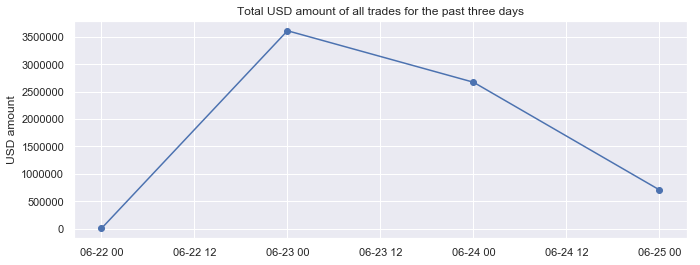

In [141]:
fig, ax = plt.subplots()
ax.plot(df2['USD amount'].sum(), marker='o', linestyle='-')
ax.set_ylabel('USD amount')
ax.set_title('Total USD amount of all trades for the past four days')